# Baseline Model Analysis

Training and evaluating the baseline black-box feedforward neural network for PK2 stress prediction from Green-Lagrange strain.

**Key approach**: Two-stage data splitting:
1. Manual scenario selection (training vs test-only scenarios)
2. Case-based splitting within training scenarios to prevent data leakage

## Configuration: Select Training and Test Scenarios

In [1]:
# Training scenarios (good coverage)
training_scenarios = [
    'uniaxial_x',
    'uniaxial_y',
    'uniaxial_x_compression',
    'uniaxial_y_compression',
    'biaxial_2to1',
    'pure_shear',
    'simple_shear'
]

# Test scenarios (for final evaluation)
test_only_scenarios = [
    'sphere',
    'equibiaxial',
    'equibiaxial_compression',
    'phi_45_plane',
    'radial_45_45'
]

RANDOM_STATE = 42

print("Training on:", training_scenarios)
print("Testing on:", test_only_scenarios)

Training on: ['uniaxial_x', 'uniaxial_y', 'uniaxial_x_compression', 'uniaxial_y_compression', 'biaxial_2to1', 'pure_shear', 'simple_shear']
Testing on: ['sphere', 'equibiaxial', 'equibiaxial_compression', 'phi_45_plane', 'radial_45_45']


In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from src.data import load_dataset, prepare_data_by_groups, get_component_names
from src.models.base_model import build_model, train_model, evaluate_model, save_results
from src.visualization import (
    plot_training_history,
    plot_predictions,
    plot_residuals,
    plot_data_distribution,
    plot_component_metrics
)

plt.rcParams['figure.figsize'] = (12, 4)

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Data

In [3]:
data_path = '../../neohookean-data-generator/data/consolidated_all.npz'

dataset = load_dataset(data_path)

print(f"Dataset loaded: {dataset['n_samples']} samples")
print(f"Strain shape: {dataset['strains'].shape}")
print(f"Stress shape: {dataset['stresses'].shape}")

strain_names, stress_names = get_component_names()
print(f"\nStrain components: {strain_names}")
print(f"Stress components: {stress_names}")

Dataset loaded: 15925 samples
Strain shape: (15925, 3)
Stress shape: (15925, 3)

Strain components: ['E_xx', 'E_yy', 'γ_xy']
Stress components: ['S_xx', 'S_yy', 'S_xy']


## 2. Split Data by Scenarios

In [4]:
strains = dataset['strains']
stresses = dataset['stresses']
scenario_labels = dataset['scenario_labels']
case_ids = dataset['case_ids']

# Create masks for training and test scenarios
train_mask = np.isin(scenario_labels, training_scenarios)
test_mask = np.isin(scenario_labels, test_only_scenarios)

# Extract training data and metadata
X_train_scenarios = strains[train_mask]
y_train_scenarios = stresses[train_mask]
case_ids_train = case_ids[train_mask]

# Extract unseen test data
X_test_unseen = strains[test_mask]
y_test_unseen = stresses[test_mask]

print(f"Training scenarios data: {len(X_train_scenarios)} samples")
print(f"Test-only scenarios data: {len(X_test_unseen)} samples")

print("\nStrain Statistics (Green-Lagrange, Voigt notation):")
for i, name in enumerate(strain_names):
    print(f"  {name}: min={strains[:, i].min():.4f}, max={strains[:, i].max():.4f}, mean={strains[:, i].mean():.4f}")

print("\nStress Statistics (PK2, Voigt notation):")
for i, name in enumerate(stress_names):
    print(f"  {name}: min={stresses[:, i].min():.1f} Pa, max={stresses[:, i].max():.1f} Pa, mean={stresses[:, i].mean():.1f} Pa")

Training scenarios data: 4375 samples
Test-only scenarios data: 11550 samples

Strain Statistics (Green-Lagrange, Voigt notation):
  E_xx: min=-0.2500, max=0.3536, mean=0.0035
  E_yy: min=-0.2500, max=0.3536, mean=0.0080
  γ_xy: min=-0.5000, max=0.7071, mean=0.0205

Stress Statistics (PK2, Voigt notation):
  S_xx: min=-3571428.6 Pa, max=1252981.7 Pa, mean=-177389.7 Pa
  S_yy: min=-3571428.6 Pa, max=1190476.2 Pa, mean=-91636.7 Pa
  S_xy: min=-3143956.5 Pa, max=3143956.5 Pa, mean=61180.1 Pa


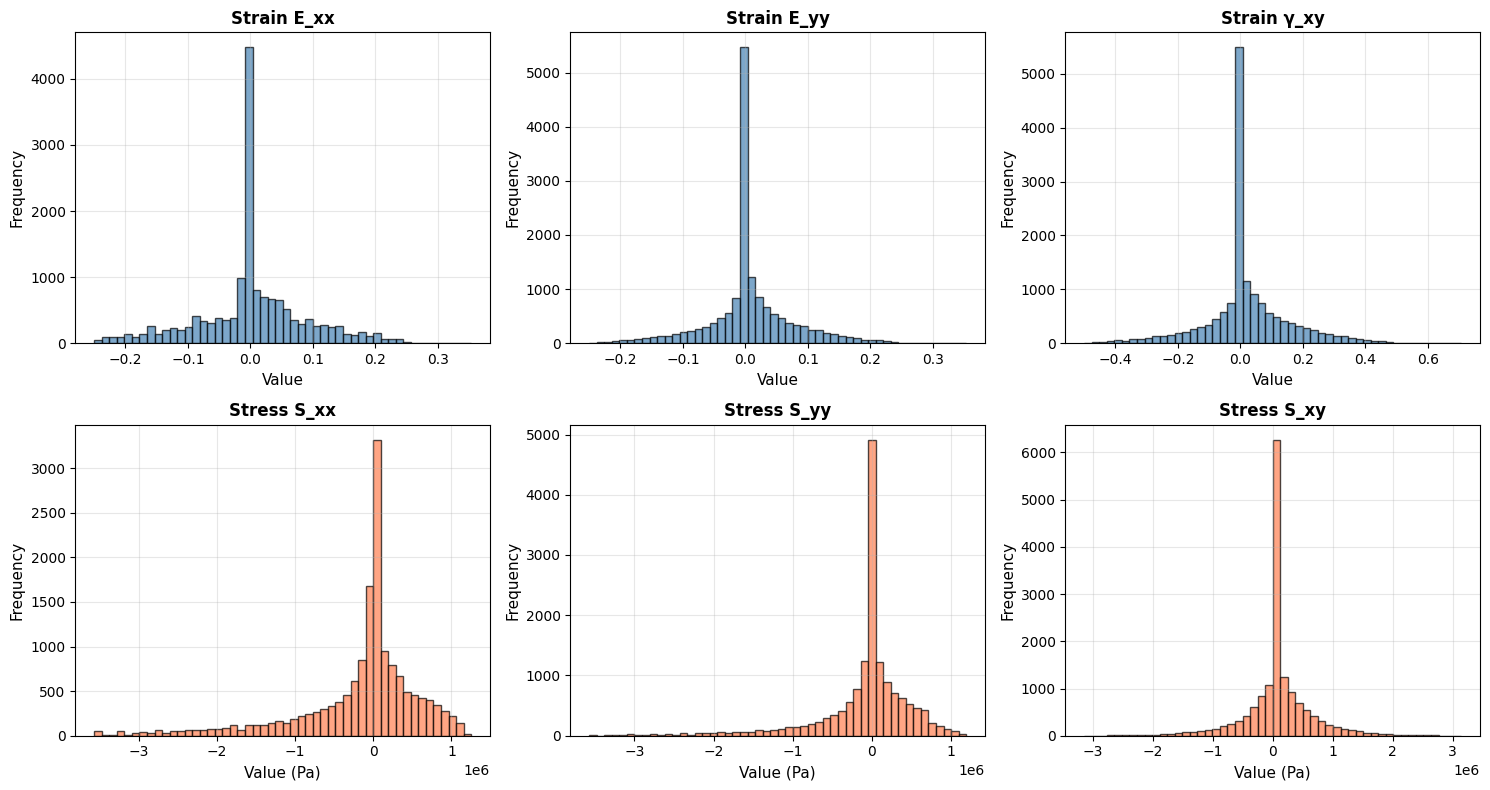

In [5]:
plot_data_distribution(strains, stresses)

## 3. Case-Based Split Within Training Scenarios

In [6]:
# Use case-based splitting within training scenarios to prevent data leakage
data = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=True, split_by='case'
)

# Scale unseen test data using same scalers
if data['X_scaler'] is not None:
    X_test_unseen_scaled = data['X_scaler'].transform(X_test_unseen)
    y_test_unseen_scaled = data['y_scaler'].transform(y_test_unseen)
else:
    X_test_unseen_scaled = X_test_unseen
    y_test_unseen_scaled = y_test_unseen

print(f"Train samples: {data['splits']['train']}")
print(f"Val samples:   {data['splits']['val']}")
print(f"Test (seen scenarios):   {data['splits']['test']}")
print(f"Test (unseen scenarios): {len(X_test_unseen)}")

Splitting by case: 175 unique groups
  Train: 105 groups, 2625 samples
  Val:   35 groups, 875 samples
  Test:  35 groups, 875 samples
  ✓ No group leakage detected
Train samples: 2625
Val samples:   875
Test (seen scenarios):   875
Test (unseen scenarios): 11550


## 4. Build Baseline Model

In [7]:
baseline_model = build_model(input_dim=3, output_dim=3, learning_rate=0.001)
baseline_model.summary()

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,843 (46.26 KB)

 Trainable params: 11,395 (44.51 KB)

 Non-trainable params: 448 (1.75 KB)

## 5. Train Baseline Model

In [8]:
baseline_history = train_model(baseline_model, data, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:21 989ms/step - loss: 2.9828 - mae: 1.3134

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2002 - mae: 0.7682 - val_loss: 0.6438 - val_mae: 0.4558 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9050 - mae: 0.6329

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.6083 - mae: 0.5433 - val_loss: 0.4887 - val_mae: 0.4082 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3958 - mae: 0.4238

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.4674 - mae: 0.4688 - val_loss: 0.3260 - val_mae: 0.3464 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4067 - mae: 0.4214

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.3990 - mae: 0.4230 - val_loss: 0.1800 - val_mae: 0.2561 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3030 - mae: 0.4195

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.3407 - mae: 0.3946 - val_loss: 0.1293 - val_mae: 0.2145 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2849 - mae: 0.4049

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.3146 - mae: 0.3801 - val_loss: 0.0646 - val_mae: 0.1573 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2342 - mae: 0.3123

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.2708 - mae: 0.3434 - val_loss: 0.0290 - val_mae: 0.1019 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1457 - mae: 0.2782

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.2550 - mae: 0.3335 - val_loss: 0.0258 - val_mae: 0.0954 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2555 - mae: 0.3178

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.2393 - mae: 0.3187 - val_loss: 0.0210 - val_mae: 0.0826 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1359 - mae: 0.2824

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.2088 - mae: 0.3005 - val_loss: 0.0226 - val_mae: 0.0790 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1416 - mae: 0.2753

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1928 - mae: 0.2897 - val_loss: 0.0168 - val_mae: 0.0772 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1081 - mae: 0.2416

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1858 - mae: 0.2812 - val_loss: 0.0151 - val_mae: 0.0726 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2339 - mae: 0.3284

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1887 - mae: 0.2793 - val_loss: 0.0207 - val_mae: 0.0726 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1176 - mae: 0.2360

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1798 - mae: 0.2722 - val_loss: 0.0203 - val_mae: 0.0736 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1274 - mae: 0.2591

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1516 - mae: 0.2594 - val_loss: 0.0159 - val_mae: 0.0674 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1095 - mae: 0.2306

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1663 - mae: 0.2625 - val_loss: 0.0163 - val_mae: 0.0699 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2542 - mae: 0.3621

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.1470 - mae: 0.2514 - val_loss: 0.0164 - val_mae: 0.0637 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0931 - mae: 0.2173

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1596 - mae: 0.2562 - val_loss: 0.0128 - val_mae: 0.0554 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1140 - mae: 0.2539

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1652 - mae: 0.2588 - val_loss: 0.0136 - val_mae: 0.0575 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2865 - mae: 0.3129

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1551 - mae: 0.2508 - val_loss: 0.0094 - val_mae: 0.0498 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0869 - mae: 0.2158

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1507 - mae: 0.2547 - val_loss: 0.0142 - val_mae: 0.0656 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3206 - mae: 0.2938

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1461 - mae: 0.2471 - val_loss: 0.0230 - val_mae: 0.0686 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1703 - mae: 0.3145

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1388 - mae: 0.2488 - val_loss: 0.0097 - val_mae: 0.0512 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0948 - mae: 0.2159

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1432 - mae: 0.2453 - val_loss: 0.0144 - val_mae: 0.0570 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0915 - mae: 0.2113

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1439 - mae: 0.2488 - val_loss: 0.0101 - val_mae: 0.0494 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1325 - mae: 0.2354

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1468 - mae: 0.2492 - val_loss: 0.0141 - val_mae: 0.0658 - learning_rate: 0.0010


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0902 - mae: 0.2008

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1383 - mae: 0.2411 - val_loss: 0.0140 - val_mae: 0.0592 - learning_rate: 0.0010


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0993 - mae: 0.2493

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1289 - mae: 0.2336 - val_loss: 0.0077 - val_mae: 0.0467 - learning_rate: 0.0010


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4173 - mae: 0.4540

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1282 - mae: 0.2375 - val_loss: 0.0133 - val_mae: 0.0678 - learning_rate: 0.0010


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1026 - mae: 0.1972

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1361 - mae: 0.2404 - val_loss: 0.0097 - val_mae: 0.0637 - learning_rate: 0.0010


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0821 - mae: 0.2002

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1399 - mae: 0.2486 - val_loss: 0.0143 - val_mae: 0.0680 - learning_rate: 0.0010


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1371 - mae: 0.2339

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1350 - mae: 0.2376 - val_loss: 0.0142 - val_mae: 0.0633 - learning_rate: 0.0010


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0989 - mae: 0.2398

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1291 - mae: 0.2401 - val_loss: 0.0071 - val_mae: 0.0550 - learning_rate: 0.0010


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1008 - mae: 0.2051

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1293 - mae: 0.2383 - val_loss: 0.0097 - val_mae: 0.0577 - learning_rate: 0.0010


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0863 - mae: 0.2244

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1295 - mae: 0.2375 - val_loss: 0.0082 - val_mae: 0.0584 - learning_rate: 0.0010


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0569 - mae: 0.1662

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1250 - mae: 0.2355 - val_loss: 0.0117 - val_mae: 0.0633 - learning_rate: 0.0010


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0936 - mae: 0.1901

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1346 - mae: 0.2451 - val_loss: 0.0099 - val_mae: 0.0547 - learning_rate: 0.0010


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1538 - mae: 0.3033

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1333 - mae: 0.2447 - val_loss: 0.0217 - val_mae: 0.0747 - learning_rate: 0.0010


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1319 - mae: 0.2059

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1258 - mae: 0.2365 - val_loss: 0.0141 - val_mae: 0.0688 - learning_rate: 0.0010


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1074 - mae: 0.2250

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1224 - mae: 0.2356 - val_loss: 0.0098 - val_mae: 0.0567 - learning_rate: 0.0010


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2568 - mae: 0.2887

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1330 - mae: 0.2422 - val_loss: 0.0156 - val_mae: 0.0617 - learning_rate: 0.0010


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1286 - mae: 0.2683

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1337 - mae: 0.2497 - val_loss: 0.0142 - val_mae: 0.0795 - learning_rate: 0.0010


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1053 - mae: 0.2349


Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1273 - mae: 0.2386 - val_loss: 0.0142 - val_mae: 0.0616 - learning_rate: 0.0010


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1066 - mae: 0.2190

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1180 - mae: 0.2359 - val_loss: 0.0098 - val_mae: 0.0616 - learning_rate: 5.0000e-04


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1502 - mae: 0.2654

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1217 - mae: 0.2374 - val_loss: 0.0075 - val_mae: 0.0543 - learning_rate: 5.0000e-04


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0679 - mae: 0.1974

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.1186 - mae: 0.2340 - val_loss: 0.0070 - val_mae: 0.0526 - learning_rate: 5.0000e-04


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.1947

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1176 - mae: 0.2360 - val_loss: 0.0080 - val_mae: 0.0582 - learning_rate: 5.0000e-04


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0836 - mae: 0.1928

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1233 - mae: 0.2433 - val_loss: 0.0104 - val_mae: 0.0524 - learning_rate: 5.0000e-04


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0983 - mae: 0.2484

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1200 - mae: 0.2400 - val_loss: 0.0090 - val_mae: 0.0610 - learning_rate: 5.0000e-04


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2645 - mae: 0.3074

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.1294 - mae: 0.2482 - val_loss: 0.0092 - val_mae: 0.0625 - learning_rate: 5.0000e-04


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0801 - mae: 0.1788

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1269 - mae: 0.2450 - val_loss: 0.0097 - val_mae: 0.0550 - learning_rate: 5.0000e-04


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1163 - mae: 0.2456

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.1173 - mae: 0.2370 - val_loss: 0.0072 - val_mae: 0.0510 - learning_rate: 5.0000e-04


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0400 - mae: 0.1567

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1099 - mae: 0.2287 - val_loss: 0.0074 - val_mae: 0.0541 - learning_rate: 5.0000e-04


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1789 - mae: 0.2351

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1084 - mae: 0.2261 - val_loss: 0.0083 - val_mae: 0.0540 - learning_rate: 5.0000e-04


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2379 - mae: 0.2842

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1101 - mae: 0.2291 - val_loss: 0.0074 - val_mae: 0.0575 - learning_rate: 5.0000e-04


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2030 - mae: 0.3131


Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1150 - mae: 0.2333 - val_loss: 0.0119 - val_mae: 0.0577 - learning_rate: 5.0000e-04


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1952 - mae: 0.2691

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1128 - mae: 0.2334 - val_loss: 0.0080 - val_mae: 0.0514 - learning_rate: 2.5000e-04


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0906 - mae: 0.2378

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.1132 - mae: 0.2322 - val_loss: 0.0066 - val_mae: 0.0492 - learning_rate: 2.5000e-04


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0570 - mae: 0.1658

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1167 - mae: 0.2318 - val_loss: 0.0068 - val_mae: 0.0532 - learning_rate: 2.5000e-04


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0776 - mae: 0.2211

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1110 - mae: 0.2306 - val_loss: 0.0081 - val_mae: 0.0500 - learning_rate: 2.5000e-04


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0840 - mae: 0.2070

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1137 - mae: 0.2323 - val_loss: 0.0104 - val_mae: 0.0558 - learning_rate: 2.5000e-04


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0978 - mae: 0.2080

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1140 - mae: 0.2368 - val_loss: 0.0069 - val_mae: 0.0531 - learning_rate: 2.5000e-04


Epoch 63/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1774 - mae: 0.3504

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.1136 - mae: 0.2360 - val_loss: 0.0063 - val_mae: 0.0493 - learning_rate: 2.5000e-04


Epoch 64/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0808 - mae: 0.2020

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.1131 - mae: 0.2329 - val_loss: 0.0083 - val_mae: 0.0499 - learning_rate: 2.5000e-04


Epoch 65/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0490 - mae: 0.1631

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1169 - mae: 0.2348 - val_loss: 0.0072 - val_mae: 0.0574 - learning_rate: 2.5000e-04


Epoch 66/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0992 - mae: 0.2190

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1122 - mae: 0.2298 - val_loss: 0.0078 - val_mae: 0.0576 - learning_rate: 2.5000e-04


Epoch 67/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - mae: 0.2061

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1167 - mae: 0.2368 - val_loss: 0.0095 - val_mae: 0.0559 - learning_rate: 2.5000e-04


Epoch 68/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0420 - mae: 0.1593

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1070 - mae: 0.2284 - val_loss: 0.0098 - val_mae: 0.0541 - learning_rate: 2.5000e-04


Epoch 69/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1424 - mae: 0.2694

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1164 - mae: 0.2367 - val_loss: 0.0091 - val_mae: 0.0563 - learning_rate: 2.5000e-04


Epoch 70/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1345 - mae: 0.2712

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1039 - mae: 0.2242 - val_loss: 0.0066 - val_mae: 0.0527 - learning_rate: 2.5000e-04


Epoch 71/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0843 - mae: 0.2371

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1118 - mae: 0.2331 - val_loss: 0.0083 - val_mae: 0.0522 - learning_rate: 2.5000e-04


Epoch 72/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0677 - mae: 0.2058

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.1139 - mae: 0.2312 - val_loss: 0.0058 - val_mae: 0.0490 - learning_rate: 2.5000e-04


Epoch 73/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1314 - mae: 0.2417

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1037 - mae: 0.2244 - val_loss: 0.0075 - val_mae: 0.0511 - learning_rate: 2.5000e-04


Epoch 74/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1068 - mae: 0.2227

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1048 - mae: 0.2249 - val_loss: 0.0071 - val_mae: 0.0545 - learning_rate: 2.5000e-04


Epoch 75/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1069 - mae: 0.2319

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1076 - mae: 0.2250 - val_loss: 0.0076 - val_mae: 0.0598 - learning_rate: 2.5000e-04


Epoch 76/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.2025

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1079 - mae: 0.2327 - val_loss: 0.0076 - val_mae: 0.0554 - learning_rate: 2.5000e-04


Epoch 77/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3724 - mae: 0.3466

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.1118 - mae: 0.2369 - val_loss: 0.0070 - val_mae: 0.0433 - learning_rate: 2.5000e-04


Epoch 78/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1260 - mae: 0.2537

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1066 - mae: 0.2282 - val_loss: 0.0070 - val_mae: 0.0502 - learning_rate: 2.5000e-04


Epoch 79/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2682 - mae: 0.3104

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1071 - mae: 0.2269 - val_loss: 0.0065 - val_mae: 0.0521 - learning_rate: 2.5000e-04


Epoch 80/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0661 - mae: 0.1995

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1049 - mae: 0.2302 - val_loss: 0.0072 - val_mae: 0.0572 - learning_rate: 2.5000e-04


Epoch 81/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2033 - mae: 0.3192

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1159 - mae: 0.2383 - val_loss: 0.0083 - val_mae: 0.0513 - learning_rate: 2.5000e-04


Epoch 82/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1319 - mae: 0.2402

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.1020 - mae: 0.2254 - val_loss: 0.0056 - val_mae: 0.0443 - learning_rate: 2.5000e-04


Epoch 83/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0914 - mae: 0.2075

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1084 - mae: 0.2306 - val_loss: 0.0118 - val_mae: 0.0514 - learning_rate: 2.5000e-04


Epoch 84/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0887 - mae: 0.2216

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1095 - mae: 0.2306 - val_loss: 0.0065 - val_mae: 0.0475 - learning_rate: 2.5000e-04


Epoch 85/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2635 - mae: 0.2593

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1027 - mae: 0.2280 - val_loss: 0.0085 - val_mae: 0.0501 - learning_rate: 2.5000e-04


Epoch 86/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0971 - mae: 0.2167

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1141 - mae: 0.2351 - val_loss: 0.0066 - val_mae: 0.0531 - learning_rate: 2.5000e-04


Epoch 87/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1295 - mae: 0.2022

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1072 - mae: 0.2262 - val_loss: 0.0105 - val_mae: 0.0536 - learning_rate: 2.5000e-04


Epoch 88/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0868 - mae: 0.1992

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1031 - mae: 0.2258 - val_loss: 0.0082 - val_mae: 0.0546 - learning_rate: 2.5000e-04


Epoch 89/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0747 - mae: 0.2159

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1076 - mae: 0.2331 - val_loss: 0.0088 - val_mae: 0.0600 - learning_rate: 2.5000e-04


Epoch 90/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1548 - mae: 0.2808

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1075 - mae: 0.2321 - val_loss: 0.0080 - val_mae: 0.0522 - learning_rate: 2.5000e-04


Epoch 91/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0656 - mae: 0.1824

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1053 - mae: 0.2281 - val_loss: 0.0101 - val_mae: 0.0600 - learning_rate: 2.5000e-04


Epoch 92/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1412 - mae: 0.2953


Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.1097 - mae: 0.2311 - val_loss: 0.0080 - val_mae: 0.0531 - learning_rate: 2.5000e-04


Epoch 93/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0674 - mae: 0.2150

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1012 - mae: 0.2233 - val_loss: 0.0083 - val_mae: 0.0504 - learning_rate: 1.2500e-04


Epoch 94/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728 - mae: 0.2042

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1101 - mae: 0.2310 - val_loss: 0.0087 - val_mae: 0.0580 - learning_rate: 1.2500e-04


Epoch 95/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0539 - mae: 0.1613

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1065 - mae: 0.2266 - val_loss: 0.0088 - val_mae: 0.0521 - learning_rate: 1.2500e-04


Epoch 96/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3187 - mae: 0.3814

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1124 - mae: 0.2364 - val_loss: 0.0074 - val_mae: 0.0506 - learning_rate: 1.2500e-04


Epoch 97/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1029 - mae: 0.2492

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.1116 - mae: 0.2359 - val_loss: 0.0085 - val_mae: 0.0515 - learning_rate: 1.2500e-04


Epoch 98/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0812 - mae: 0.2047

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1126 - mae: 0.2352 - val_loss: 0.0083 - val_mae: 0.0518 - learning_rate: 1.2500e-04


Epoch 99/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0637 - mae: 0.1849

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.1032 - mae: 0.2249 - val_loss: 0.0081 - val_mae: 0.0498 - learning_rate: 1.2500e-04


Epoch 100/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0715 - mae: 0.1933

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.1000 - mae: 0.2188 - val_loss: 0.0080 - val_mae: 0.0533 - learning_rate: 1.2500e-04


Restoring model weights from the end of the best epoch: 82.


## 6. Training History

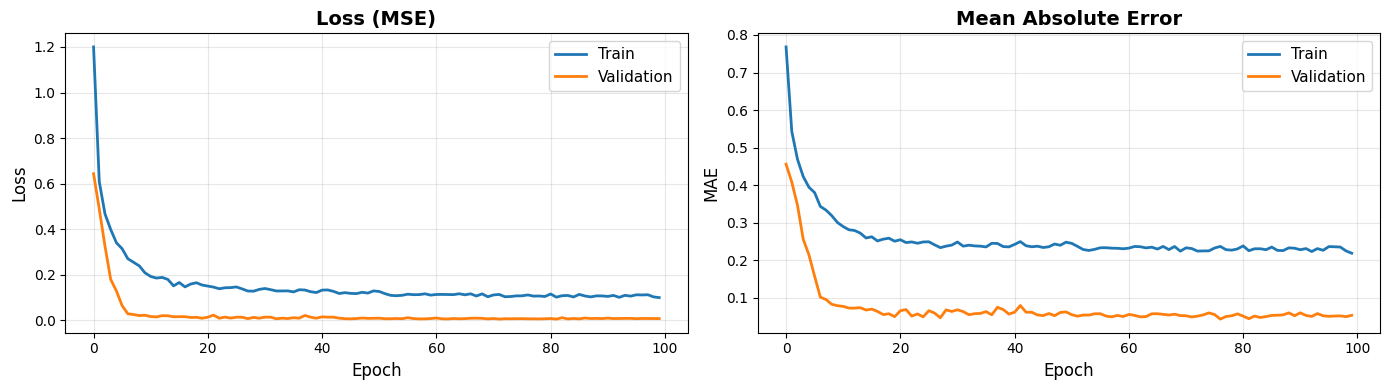

In [9]:
plot_training_history(baseline_history)

## 7. Evaluate on Seen Test Scenarios

In [10]:
print("=" * 70)
print("EVALUATION ON SEEN TEST SCENARIOS")
print("(from training scenarios, but different cases)")
print("=" * 70)

metrics_seen, _ = evaluate_model(baseline_model, data)

print(f"\nOverall Metrics (Seen):")
print(f"  MAE:  {metrics_seen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_seen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_seen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Seen):")
for comp in stress_names:
    mae = metrics_seen['components'][comp]['mae']
    r2 = metrics_seen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON SEEN TEST SCENARIOS
(from training scenarios, but different cases)



Overall Metrics (Seen):
  MAE:  16436.26 Pa
  RMSE: 23725.38 Pa
  R²:   0.9944

Component-wise Metrics (Seen):
  S_xx: MAE = 18532.52 Pa, R² = 0.9935
  S_yy: MAE = 20228.83 Pa, R² = 0.9924
  S_xy: MAE = 10547.41 Pa, R² = 0.9973


## 8. Evaluate on Unseen Test Scenarios

In [11]:
print("=" * 70)
print("EVALUATION ON UNSEEN TEST SCENARIOS")
print("(completely new scenarios, never seen during training)")
print("=" * 70)

# Prepare unseen test data in same format as data dict
data_unseen = {
    'X_test': X_test_unseen_scaled,
    'y_test': y_test_unseen_scaled,
    'y_test_original': y_test_unseen,
    'X_scaler': data['X_scaler'],
    'y_scaler': data['y_scaler']
}

metrics_unseen, _ = evaluate_model(baseline_model, data_unseen)

print(f"\nOverall Metrics (Unseen):")
print(f"  MAE:  {metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_unseen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Unseen):")
for comp in stress_names:
    mae = metrics_unseen['components'][comp]['mae']
    r2 = metrics_unseen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON UNSEEN TEST SCENARIOS
(completely new scenarios, never seen during training)



Overall Metrics (Unseen):
  MAE:  192435.14 Pa
  RMSE: 368274.20 Pa
  R²:   0.7284

Component-wise Metrics (Unseen):
  S_xx: MAE = 212876.28 Pa, R² = 0.7929
  S_yy: MAE = 164879.00 Pa, R² = 0.7401
  S_xy: MAE = 199550.14 Pa, R² = 0.6523


## 9. Comparison: Seen vs Unseen Performance

In [12]:
print("=" * 70)
print("PERFORMANCE COMPARISON: SEEN vs UNSEEN SCENARIOS")
print("=" * 70)

print(f"\nOverall Metrics:")
print(f"  MAE:  Seen = {metrics_seen['mae']:.2f} Pa  |  Unseen = {metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: Seen = {metrics_seen['rmse']:.2f} Pa  |  Unseen = {metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   Seen = {metrics_seen['r2']:.4f}  |  Unseen = {metrics_unseen['r2']:.4f}")

print(f"\nDegradation (Unseen vs Seen):")
mae_degradation = ((metrics_unseen['mae'] - metrics_seen['mae']) / metrics_seen['mae']) * 100
rmse_degradation = ((metrics_unseen['rmse'] - metrics_seen['rmse']) / metrics_seen['rmse']) * 100
r2_degradation = ((metrics_seen['r2'] - metrics_unseen['r2']) / metrics_seen['r2']) * 100

print(f"  MAE increase:  {mae_degradation:+.1f}%")
print(f"  RMSE increase: {rmse_degradation:+.1f}%")
print(f"  R² decrease:   {r2_degradation:+.1f}%")

PERFORMANCE COMPARISON: SEEN vs UNSEEN SCENARIOS

Overall Metrics:
  MAE:  Seen = 16436.26 Pa  |  Unseen = 192435.14 Pa
  RMSE: Seen = 23725.38 Pa  |  Unseen = 368274.20 Pa
  R²:   Seen = 0.9944  |  Unseen = 0.7284

Degradation (Unseen vs Seen):
  MAE increase:  +1070.8%
  RMSE increase: +1452.2%
  R² decrease:   +26.7%


## 10. Visualization: Predictions

Predictions on Seen Test Scenarios:


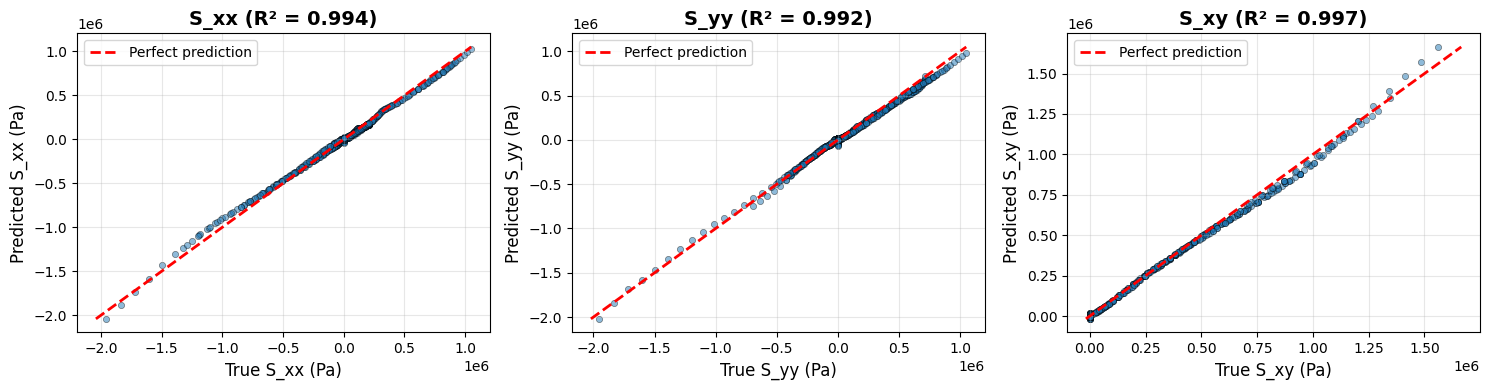

In [13]:
print("Predictions on Seen Test Scenarios:")
y_pred_seen_scaled = baseline_model.predict(data['X_test'], verbose=0)
y_pred_seen = data['y_scaler'].inverse_transform(y_pred_seen_scaled)
plot_predictions(data['y_test_original'], y_pred_seen)

Predictions on Unseen Test Scenarios:


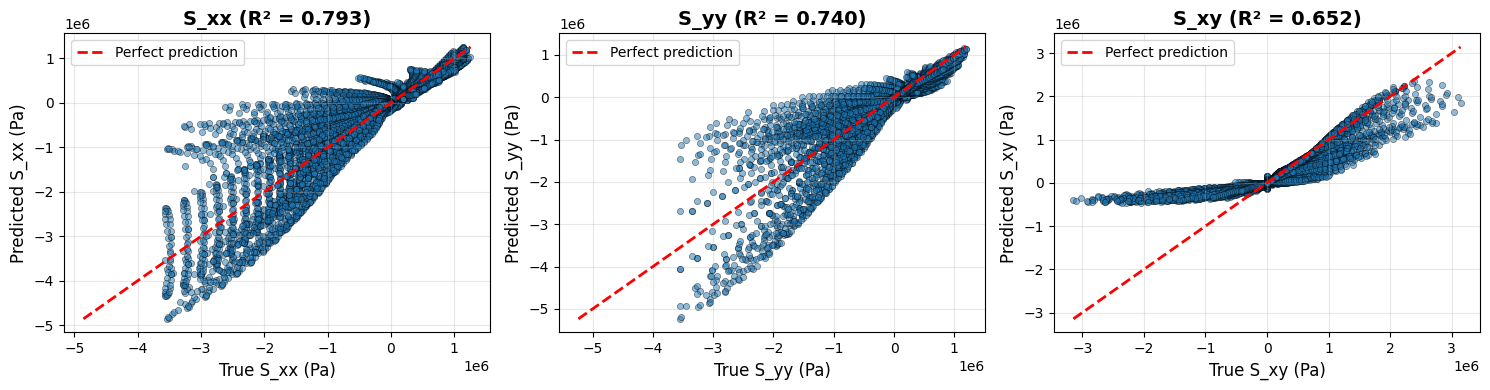

In [14]:
print("Predictions on Unseen Test Scenarios:")
y_pred_unseen_scaled = baseline_model.predict(data_unseen['X_test'], verbose=0)
y_pred_unseen = data_unseen['y_scaler'].inverse_transform(y_pred_unseen_scaled)
plot_predictions(data_unseen['y_test_original'], y_pred_unseen)

## 11. Visualization: Residuals

Residuals on Seen Test Scenarios:


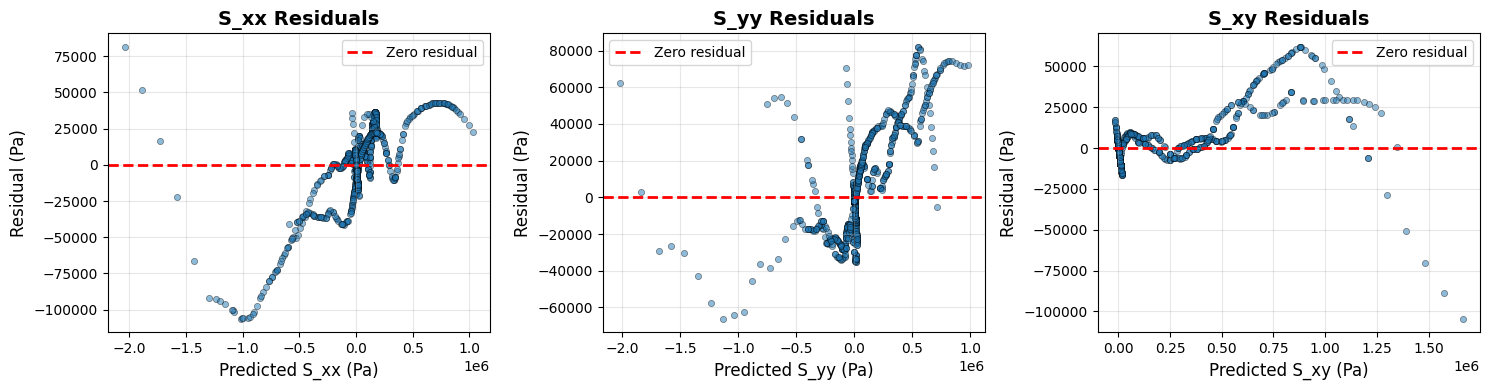

In [15]:
print("Residuals on Seen Test Scenarios:")
plot_residuals(data['y_test_original'], y_pred_seen)

Residuals on Unseen Test Scenarios:


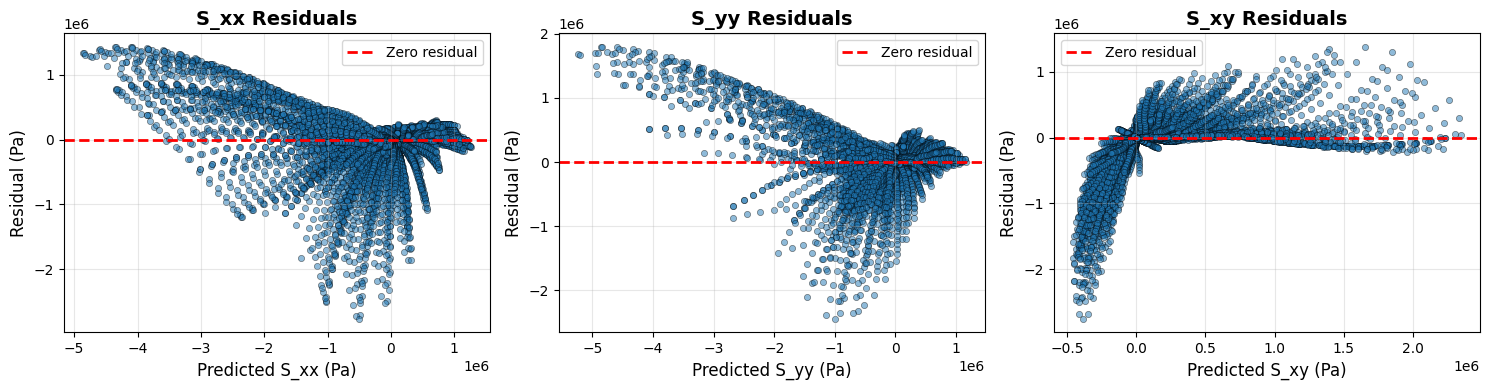

In [16]:
print("Residuals on Unseen Test Scenarios:")
plot_residuals(data_unseen['y_test_original'], y_pred_unseen)

## 12. Component-wise Performance

Component-wise Performance on Seen Test Scenarios:


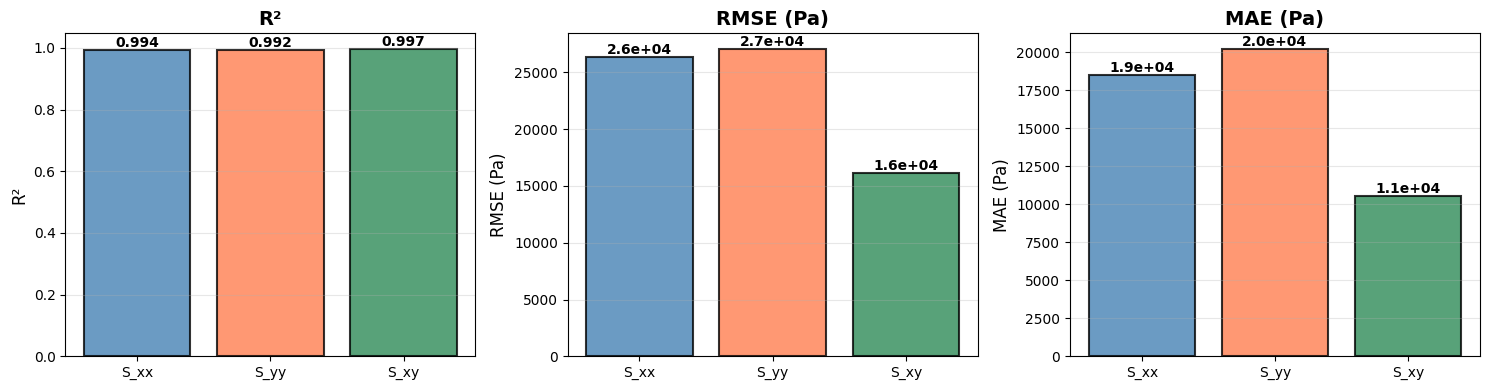

In [17]:
print("Component-wise Performance on Seen Test Scenarios:")
plot_component_metrics(metrics_seen)

Component-wise Performance on Unseen Test Scenarios:


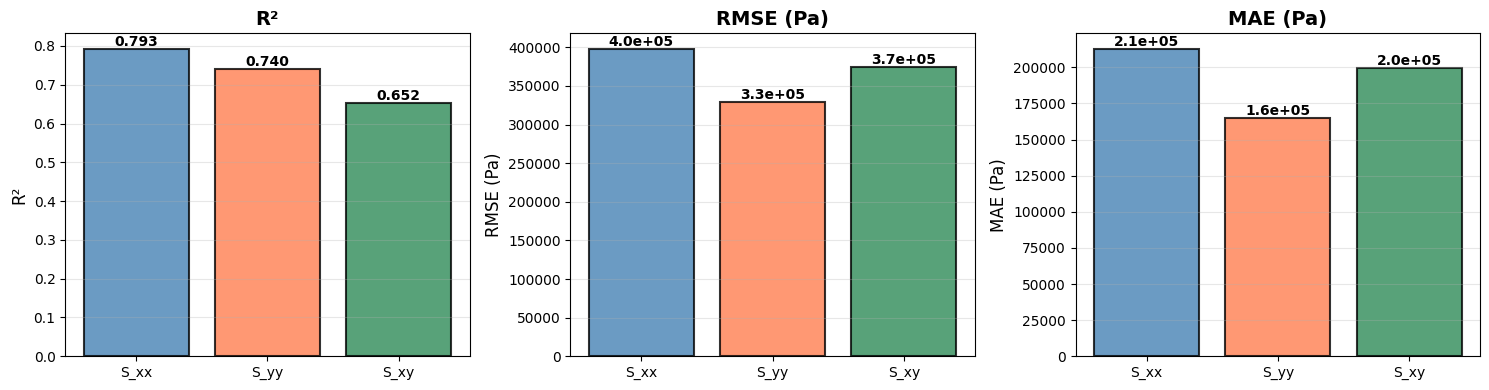

In [18]:
print("Component-wise Performance on Unseen Test Scenarios:")
plot_component_metrics(metrics_unseen)

## 13. Save Results

In [19]:
# Save model and results
import json
from pathlib import Path

results_dir = Path('../results/baseline')
results_dir.mkdir(parents=True, exist_ok=True)

# Save model
baseline_model.save(results_dir / 'model.h5')

# Save training history
history_dict = {
    'loss': [float(x) for x in baseline_history.history['loss']],
    'val_loss': [float(x) for x in baseline_history.history['val_loss']],
    'mae': [float(x) for x in baseline_history.history['mae']],
    'val_mae': [float(x) for x in baseline_history.history['val_mae']]
}
with open(results_dir / 'history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

# Save seen metrics
with open(results_dir / 'seen_metrics.json', 'w') as f:
    json.dump({
        'mae': float(metrics_seen['mae']),
        'rmse': float(metrics_seen['rmse']),
        'r2': float(metrics_seen['r2']),
        'components': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in metrics_seen['components'].items()}
    }, f, indent=2)

# Save unseen metrics
with open(results_dir / 'unseen_metrics.json', 'w') as f:
    json.dump({
        'mae': float(metrics_unseen['mae']),
        'rmse': float(metrics_unseen['rmse']),
        'r2': float(metrics_unseen['r2']),
        'components': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in metrics_unseen['components'].items()}
    }, f, indent=2)

print(f"\nResults saved to {results_dir}")
print(f"  - Model weights: model.h5")
print(f"  - Training history: history.json")
print(f"  - Seen test metrics: seen_metrics.json")
print(f"  - Unseen test metrics: unseen_metrics.json")


Results saved to ../results/baseline
  - Model weights: model.h5
  - Training history: history.json
  - Seen test metrics: seen_metrics.json
  - Unseen test metrics: unseen_metrics.json
